In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker
import numpy as np
import matplotlib.dates as mdates
import datetime as dt
import matplotlib.patches as patches

from matplotlib.ticker import FuncFormatter
from matplotlib.dates import MonthLocator, DateFormatter 

from labellines import labelLine, labelLines

!pip install lmfit
import lmfit
from lmfit import Minimizer, Parameters, report_fit

data_uk_all = np.genfromtxt("https:\\github.com\\lwyakob\\COVIDsaturates\\master\\cov_UK_Aug.txt")#data 
data_uk_fit = np.genfromtxt("https:\\github.com\\lwyakob\\COVIDsaturates\\master\\cov_data_Aug.txt")#data location

In [3]:
# parameters
N_START = 56_000_000# England 

#dd transmission
beta_set = 1.0e-8#sat_Corn=1.56 sat_Av=1.31 Lon=1.08 (ie scaled_equiv_r0); otherwise 1.0e-8 (for dd and fd)

#fd transmission
betaf = 1e-8 * N_START   
      

rho=0.02 # prop become critically ill [DOI: 10.1001/jama.2020.2648]
a = 1/5.8 #5.8 days incubation [DOI: 10.1101/2020.01.27.20018986]
a2 = 1/7 #7 further days to become critically ill (14d to die, 7d of which in ICU=7d) [doi.org/10.1002/jmv.25689]
mort = 0.427 #prop of critically ill that die [beta.isdscotland.org/find-publications-and-data/population-health/covid-19/
#                                              scottish-intensive-care-society-audit-group-report-on-covid-19/]
t_die = 1/7 #days to die following becoming critically ill [doi: 10.1016/S2213-2600(20)30103-X]
gamma = 1/5 #5 days to recover [https://doi.org/10.1016/S1473-3099(20)30232-2] 90% not infectious by day 10 = 20%daily recovery
gamma2 = 1/7.2 #7.2 days to recover from critically ill [SICS Audit as above]

emig = 0.1 # daily mixing between 'free' indivs and locked down indivs i.e. these are NOT 2 closed pops

Z = 2000 # number of days
index_set = range(Z+1)
S = np.zeros(len(index_set))
E = np.zeros(len(index_set))
I = np.zeros(len(index_set))
pcI = np.zeros(len(index_set))
cI = np.zeros(len(index_set))
R = np.zeros(len(index_set))
D = np.zeros(len(index_set))
LS = np.zeros(len(index_set))
LE = np.zeros(len(index_set))
LI = np.zeros(len(index_set))
LpcI = np.zeros(len(index_set))
LcI = np.zeros(len(index_set))
LR = np.zeros(len(index_set))
LD = np.zeros(len(index_set))
cur_D = np.zeros(len(index_set))
PULSE1 = np.zeros(len(index_set))
PULSE2 = np.zeros(len(index_set))
im = np.zeros(len(index_set))
em = np.zeros(len(index_set))
free = np.zeros(len(index_set))
home = np.ones(len(index_set))
helper = np.ones(len(index_set))
empty = np.zeros(len(index_set))
transit = np.zeros(len(index_set))
rec = np.zeros(len(index_set))
counter = np.zeros(len(index_set))
icu = np.zeros(len(index_set))

soc_dis = 1# proportion of social contacting among free-movers AFTER lock down
Lock = 96#96 #day that lockdown begins 
Prop_Lock = 0.84# prop undergoing lockdown
Release = 167 # day that lockdown begins release 
gradual = 30#365 # extends days that release takes place over
release_days = 1# counter for actual no. release days (starts at 1 as it STOPS the day before final release) 
fitter = 1
NHS_over = 1000

In [4]:
#math model
def math_model(dd_free, dd_home, gradual, soc_dis, fitter, popdens, Lock):
   
    
    helper[0:Release-1] = 0

    free[0] = N_START
    S[0] = N_START - 13 
    E[0] = 3            
    I[0] = 10           
    PULSE1[Lock+1] = Prop_Lock # proportion shifted into Lockdown
           
    if dd_home == 0:
        if dd_free == 2:
            Lbetaf = 1e-8 * N_START * fitter#prev beta_set * N_START * fitter 
        elif dd_free == 1:
            Lbetaf = 1e-8 * N_START * fitter#prev beta_set * N_START * fitter
        else:
            Lbetaf = 1e-8 * N_START * fitter#prev beta_set * N_START * fitter
    
    #dd in lockdown sub-pop nonsensicle so this presently not used...
    else:
        if dd_free == 1:
            Lbeta = 1e-8 * fitter#prev beta_set * fitter
        else:
            Lbeta = 1e-8 * fitter#prev beta_set * fitter
    
    
    counter = np.zeros(len(index_set))
    icu = np.zeros(len(index_set))
    
    for n in index_set[1:]:
        
        if n < Lock+1:
            beta = beta_set
            betaf = beta_set * N_START
        
        else: 
            beta = beta_set * soc_dis #i.e. social distancing among free-movers effected from lockdown
            betaf = beta_set * N_START * soc_dis

        #people NOT in Lockdown
        if dd_free == 2:
            S[n] = (S[n-1] - S[n-1] * ((betaf / (free[n-1])) * (I[n-1]+pcI[n-1]) 
                    * (2*0.031*popdens*((free[n-1])/N_START)/(1+2*0.031*popdens*((free[n-1])/N_START)
                                                              +(1+4*0.031*popdens*((free[n-1])/N_START))**0.5))
                                       + em[n-1]) * (1-PULSE1[n-1])
              - PULSE1[n-1] * S[n-1] + PULSE2[n-1] * LS[n-1]**2 + (im[n-1]) * LS[n-1])

            E[n] = (E[n-1] + ((betaf / (free[n-1])) * S[n-1] * (I[n-1]+pcI[n-1]) 
                    * (2*0.031*popdens*((free[n-1])/N_START)/(1+2*0.031*popdens*((free[n-1])/N_START)
                                                              +(1+4*0.031*popdens*((free[n-1])/N_START))**0.5))               
                              - (a + em[n-1]) * E[n-1]) * (1-PULSE1[n-1])
              - PULSE1[n-1] * E[n-1] + PULSE2[n-1] * LE[n-1]**2 + (im[n-1]) * LE[n-1])
            
        elif dd_free == 1:
            S[n] = (S[n-1] - (S[n-1] * (beta * (I[n-1]+pcI[n-1]) + em[n-1])) * (1-PULSE1[n-1])
              - PULSE1[n-1] * S[n-1] + PULSE2[n-1] * LS[n-1]**2 + (im[n-1]) * LS[n-1])

            E[n] = (E[n-1] + (beta * S[n-1] * (I[n-1]+pcI[n-1]) - (a + em[n-1]) * E[n-1]) * (1-PULSE1[n-1])
              - PULSE1[n-1] * E[n-1] + PULSE2[n-1] * LE[n-1]**2 + (im[n-1]) * LE[n-1])
        else:
            S[n] = (S[n-1] - S[n-1] * ((betaf / (free[n-1])) * (I[n-1]+pcI[n-1]) + em[n-1]) * (1-PULSE1[n-1])
              - PULSE1[n-1] * S[n-1] + PULSE2[n-1] * LS[n-1]**2 + (im[n-1]) * LS[n-1])

            E[n] = (E[n-1] + ((betaf / (free[n-1])) * S[n-1] * (I[n-1]+pcI[n-1]) - (a + em[n-1]) * E[n-1]) * (1-PULSE1[n-1])
              - PULSE1[n-1] * E[n-1] + PULSE2[n-1] * LE[n-1]**2 + (im[n-1]) * LE[n-1])

        I[n] = (I[n-1] + ((1 - rho) * a * E[n-1] - (gamma + em[n-1]) * I[n-1]) * (1-PULSE1[n-1])
              - PULSE1[n-1] * I[n-1] + PULSE2[n-1] * LI[n-1]**2 + (im[n-1]) * LI[n-1])

        pcI[n] = (pcI[n-1] + (rho * a * E[n-1] - (a2 + em[n-1]) * pcI[n-1]) * (1-PULSE1[n-1])
                - PULSE1[n-1] * pcI[n-1] + PULSE2[n-1] * LpcI[n-1]**2 + (im[n-1]) * LpcI[n-1])

        cI[n] = (cI[n-1] + (a2 * pcI[n-1] - (mort * t_die + em[n-1] + (1 - mort) * gamma2) * cI[n-1]) * (1-PULSE1[n-1])
               - PULSE1[n-1] * cI[n-1] + PULSE2[n-1] * LcI[n-1]**2 + (im[n-1]) * LcI[n-1])

        R[n] = (R[n-1] + (gamma * I[n-1] + (1 - mort) * gamma2 * cI[n-1] - em[n-1] * R[n-1]) * (1-PULSE1[n-1])
              - PULSE1[n-1] * R[n-1] + PULSE2[n-1] * LR[n-1]**2 + (im[n-1]) * LR[n-1])

        D[n] = D[n-1] + mort * t_die * cI[n-1]

        free[n] = S[n]+E[n]+I[n]+pcI[n]+cI[n]+R[n]

        #people in Lockdown
        if dd_home == 1:
            LS[n] = np.clip( (LS[n-1] - (LS[n-1] * (Lbeta * (LI[n-1]+LpcI[n-1]) + im[n-1] + empty[n-1]))
               + PULSE1[n-1] * S[n-1] - PULSE2[n-1] * LS[n-1]**2 + em[n-1] * S[n-1] * (1-PULSE1[n-1]))
                            ,0,N_START)

            LE[n] = np.clip( (LE[n-1] + (Lbeta * LS[n-1] * (LI[n-1]+LpcI[n-1]) - (a + im[n-1] + empty[n-1]) * LE[n-1])
               + PULSE1[n-1] * E[n-1] - PULSE2[n-1] * LE[n-1]**2 + em[n-1] * E[n-1] * (1-PULSE1[n-1]))
                            ,0,N_START)
        else:
            LS[n] = np.clip( (LS[n-1] - LS[n-1] * ((Lbetaf/(home[n-1])) * (LI[n-1]+LpcI[n-1]) + im[n-1] + empty[n-1])
               + PULSE1[n-1] * S[n-1] - PULSE2[n-1] * LS[n-1]**2 + em[n-1] * S[n-1] * (1-PULSE1[n-1]))
                            ,0,N_START)

            LE[n] = np.clip( (LE[n-1] + LS[n-1] * ((Lbetaf/(home[n-1])) * (LI[n-1]+LpcI[n-1])) - (a + im[n-1] + empty[n-1]) * LE[n-1])
               + PULSE1[n-1] * E[n-1] - PULSE2[n-1] * LE[n-1]**2 + em[n-1] * E[n-1] * (1-PULSE1[n-1])
                            ,0,N_START)

        LI[n] = np.clip( (LI[n-1] + ((1 - rho) * a * LE[n-1] - (gamma + im[n-1] + empty[n-1]) * LI[n-1])
                 + PULSE1[n-1] * I[n-1] - PULSE2[n-1] * LI[n-1]**2 + em[n-1] * I[n-1] * (1-PULSE1[n-1]))
                        ,0,N_START)

        LpcI[n] = np.clip( (LpcI[n-1] + (rho * a * LE[n-1] - (a2 + im[n-1] + empty[n-1]) * LpcI[n-1])
                 + PULSE1[n-1] * pcI[n-1] - PULSE2[n-1] * LpcI[n-1]**2 + em[n-1] * pcI[n-1] * (1-PULSE1[n-1]))
                          ,0,N_START)

        LcI[n] = np.clip( (LcI[n-1] + (a2 * LpcI[n-1] - (mort * t_die + im[n-1] + (1-mort) * gamma2 + empty[n-1]) * LcI[n-1])
                + PULSE1[n-1] * cI[n-1] - PULSE2[n-1] * LcI[n-1]**2 + em[n-1] * cI[n-1] * (1-PULSE1[n-1]))
                         ,0,N_START)

        LR[n] = np.clip( (LR[n-1] + ((gamma * LI[n-1] + (1 - mort) * gamma2 * LcI[n-1]) - (im[n-1] + empty[n-1]) * LR[n-1])
               + PULSE1[n-1] * R[n-1] - PULSE2[n-1] * LR[n-1]**2 + em[n-1] * R[n-1] * (1-PULSE1[n-1]))
                        ,0,N_START)

        LD[n] = LD[n-1] + mort * t_die * LcI[n-1]
        
        cur_D[n] = D[n] + LD[n]

        home[n] = LS[n]+LE[n]+LI[n]+LpcI[n]+LcI[n]+LR[n]+1e-20
        
        em[Lock]=emig
        
        
        #This stops movement after all living locked down people have been released
        if home[n-1] - 2*(home[n-3] - home[n-2]) <= LD[n-1]:
            em[n] = 0
        elif n > Lock and em[n-1] > 0:
            em[n] = emig
        else:
            em[n] = 0
    
        if free[n-3] + 2*(free[n-4] - free[n-5]) > N_START - D[n-2] - LD[n-2]:
            im[n]=0
       
        else:
            im[n] = em[n] * ((free[n]) / (home[n]+1)) # +1 stops divide by zero
        
        transit[n] = em[n] * (I[n]+pcI[n]+cI[n]) + im[n] * (LI[n]+LpcI[n]+LcI[n])

        marker = home[Release-1] #Locked down pop at start of Release

       
        if free[n-1] + 2*(free[n-2] - free[n-3]) > N_START - D[n-1] - LD[n-1]:   
            PULSE2[n] = 0
        elif n > Release and PULSE2[n-1] == 0:
            PULSE2[n] = 0
        else:
            PULSE2[n] = helper[n] * (marker / (home[n] + 1)) * (1/gradual) * (1/(home[n] + 1))

        
        if n > Release and PULSE2[n] ==0:
            empty[n] = 0#1

        if n > Release and PULSE2[n-1] ==0: 
            PULSE2[n]= 0
            
        if n > Release and cur_D[n] > cur_D[n-1] + 300:
            counter[n] = 1
            
        if n > Release+1 and cI[n] + LcI[n] > 5000:
            icu[n] = 1

    release_days = np.count_nonzero(PULSE2)
           
    return (home, free, S, E, I, pcI, cI, R, D, LS, LE, LI, LpcI, LcI, LR, LD, cur_D, 
            transit, release_days, em, im, counter, fitter, icu)

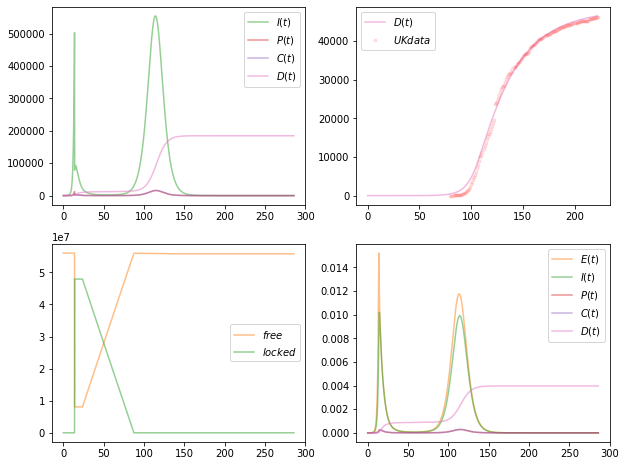

In [8]:
A1 = math_model(dd_free=0, dd_home=0, gradual=365, soc_dis=0.5, fitter=0.21, popdens=432, Lock=96)
satS=np.array(A1[2]+A1[9])
satE=np.array(A1[3]+A1[10])
satI=np.array(A1[4]+A1[11])
satP=np.array(A1[5]+A1[12])
satC=np.array(A1[6]+A1[13])
satR=np.array(A1[7]+A1[14])
satD=np.array(A1[8]+A1[15])

ep_wk = np.arange(0, 2000/7, 1/7).tolist() 

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=[10, 8])

ax1.plot(ep_wk, I, color ='C2', alpha=0.5, label=f'$I(t)$')
ax1.plot(ep_wk, pcI, color ='C3', alpha=0.5, label=f'$P(t)$')
ax1.plot(ep_wk, cI, color ='C4', alpha=0.5, label=f'$C(t)$')
ax1.plot(ep_wk, D, color ='C6', alpha=0.5, label=f'$D(t)$')

ax1.legend()


xx = data_uk_all[:,0]
yy = data_uk_all[:,1]

ax2.plot(satD[0:223], color ='C6', alpha=0.5, label=f'$D(t)$')
ax2.plot(xx, yy,'r.', alpha=0.1, label=f'$UK data$') 
ax2.legend()


ax3.plot(ep_wk, free, color ='C1', alpha=0.5, label=f'$free$')
ax3.plot(ep_wk, home, color ='C2', alpha=0.5, label=f'$locked$')
ax3.legend()


ax4.plot(ep_wk, (E+LE)/N_START, color ='C1', alpha=0.5, label=f'$E(t)$')
ax4.plot(ep_wk, (I+LI)/N_START, color ='C2', alpha=0.5, label=f'$I(t)$')
ax4.plot(ep_wk, (pcI+LpcI)/N_START, color ='C3', alpha=0.5, label=f'$P(t)$')
ax4.plot(ep_wk, (cI+LcI)/N_START, color ='C4', alpha=0.5, label=f'$C(t)$')
ax4.plot(ep_wk, (D+LD)/N_START, color ='C6', alpha=0.5, label=f'$D(t)$')
ax4.legend()
